# **Project Scope and Motivation**

Spotify’s recommendation system is good, but I believe it could be better. Often, it doesn't fully capture my unique music preferences, leaving room for improvement. Instead of relying on their algorithm, I’ve decided to take an exciting step toward building my own personalized recommendation system.

Using my streaming data and cutting-edge data science techniques, I aim to create a platform that truly understands my listening habits. This project isn’t just about fixing what’s missing—it's about exploring new ways to discover music that resonates with me, making the process of finding my next favorite track more rewarding and enjoyable.

In [30]:
!pip install pandas numpy matplotlib seaborn scikit-learn spotipy

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import spotipy
import time
import os
import re
import requests
import kagglehub
import base64
import json
import sys
import itertools
from spotipy.oauth2 import SpotifyClientCredentials
from numpy import cumsum, sort
from google.colab import files
from difflib import SequenceMatcher
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler


from spotipy.oauth2 import SpotifyClientCredentials
from spotipy.oauth2 import SpotifyOAuth
import spotipy.util as util

import warnings
warnings.filterwarnings("ignore")

In [4]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

### **Data Collection Process**

For this project, I used my personal streaming history data from Spotify. Spotify allows users to download their listening history, which provides detailed insights into their music preferences. Here's how I collected and uploaded my data into the Colab environment:

1. **Downloading Data from Spotify**:
   - Go to the **Spotify Privacy Settings** page (under Account settings).
   - Request your data by selecting the **Download Your Data** option. Spotify will email you a link to download your streaming history as a JSON file after processing your request.
   - The data includes information like track names, artists, timestamps, and listening duration.

2. **Uploading Data to Colab**:
   - Once you receive the JSON files, download them to your local machine.
   - In your Colab notebook:
     - Use the upload button in the file browser to upload the JSON files.


This process ensures that the data being analyzed and used for the recommendation system is uniquely tailored to your listening history, paving the way for a highly personalized experience.

In [7]:
# Choose whether to upload files or use predefined file paths
use_uploaded_files = False  # Set to False to use predefined file paths

if use_uploaded_files:
    # Upload files manually
    print("Please upload the JSON files:")
    uploaded = files.upload()

    # Load uploaded files into DataFrames
    df_video = pd.read_json(list(uploaded.keys())[0])  # Assumes order of upload: video file first
    df_audio_1 = pd.read_json(list(uploaded.keys())[1])
    df_audio_2 = pd.read_json(list(uploaded.keys())[2])
    df_audio_3 = pd.read_json(list(uploaded.keys())[3])
    df_audio_4 = pd.read_json(list(uploaded.keys())[4])
else:
    # Use predefined file paths
    file_video = '/content/Streaming_History_Video_2022-2025.json'
    file_audio_1 = '/content/Streaming_History_Audio_2018-2022_0.json'
    file_audio_2 = '/content/Streaming_History_Audio_2022-2023_1.json'
    file_audio_3 = '/content/Streaming_History_Audio_2023-2024_2.json'
    file_audio_4 = '/content/Streaming_History_Audio_2024-2025_3.json'

    # Load files into DataFrames
    df_video = pd.read_json(file_video)
    df_audio_1 = pd.read_json(file_audio_1)
    df_audio_2 = pd.read_json(file_audio_2)
    df_audio_3 = pd.read_json(file_audio_3)
    df_audio_4 = pd.read_json(file_audio_4)

### **Combining and Transforming Audio Data**

In this step, we combine multiple audio streaming datasets into a single DataFrame and extract useful features for analysis.

1. **Combining Data**:  
   - The `pd.concat` function merges multiple DataFrames (`df_audio_1`, `df_audio_2`, etc.) into one (`df_audio`) for a unified analysis.  
   - Using `ignore_index=True` resets the index in the combined DataFrame.

2. **Processing Timestamps**:  
   - The `ts` column is converted into a datetime format for easy manipulation.  
   - Key components such as `date`, `year`, `month`, `day_of_week`, and `hour` are extracted. These features help in analyzing listening habits over time.

3. **Converting Listening Duration**:  
   - The `ms_played` column is converted from milliseconds to minutes (`minutes_played`) for better readability and analysis.

4. **Data Overview**:  
   - The `.info()` method displays the structure and completeness of the video (`df_video`) and audio (`df_audio`) datasets, ensuring they are ready for analysis.  
   - This step helps verify data integrity and identify missing values or anomalies.

In [8]:
# Combine all audio data into a single DataFrame
df_audio = pd.concat([df_audio_1, df_audio_2, df_audio_3, df_audio_4], ignore_index=True)

# Convert timestamps to datetime and extract useful features
df_audio['datetime'] = pd.to_datetime(df_audio['ts'])
df_audio['date'] = df_audio['datetime'].dt.date
df_audio['year'] = df_audio['datetime'].dt.year
df_audio['month'] = df_audio['datetime'].dt.month
df_audio['day_of_week'] = df_audio['datetime'].dt.day_name()
df_audio['hour'] = df_audio['datetime'].dt.hour
df_audio['minutes_played'] = df_audio['ms_played'] / 60000  # Convert ms to minutes

# Display basic info about the datasets
print("Video DataFrame Info:")
print(df_video.info())

print("\nAudio DataFrame Info:")
print(df_audio.info())

Video DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63 entries, 0 to 62
Data columns (total 23 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   ts                                 63 non-null     object 
 1   platform                           63 non-null     object 
 2   ms_played                          63 non-null     int64  
 3   conn_country                       63 non-null     object 
 4   ip_addr                            63 non-null     object 
 5   master_metadata_track_name         40 non-null     object 
 6   master_metadata_album_artist_name  40 non-null     object 
 7   master_metadata_album_album_name   40 non-null     object 
 8   spotify_track_uri                  40 non-null     object 
 9   episode_name                       23 non-null     object 
 10  episode_show_name                  23 non-null     object 
 11  spotify_episode_uri                23 

### **Exploratory Data Analysis (EDA): Top Tracks Over the Years**

To better understand my listening habits, I decided to analyze the most popular tracks for each year based on total listening time. Instead of limiting the analysis to a single year, I wanted to aggregate data across all available years and wrap it into a combined overview. This approach not only highlights yearly trends but also provides a more comprehensive perspective on how my preferences have evolved over time.

EDA is a crucial step in any data-driven project as it helps uncover patterns, trends, and insights that can shape the rest of the analysis or recommendation system design. In this case, it helps identify which tracks dominated each year and understand the diversity in my listening behavior.

---



### **Top Played Tracks Each Year**

This code identifies and visualizes the top 10 most played tracks for each year in my dataset. Here's what it accomplishes:

1. **Aggregating Listening Time**:
   - It calculates the total listening time (in minutes) for each track within a given year. This helps determine which tracks were most popular based on how much they were played.

2. **Selecting Top 10 Tracks Per Year**:
   - After calculating the total listening time for all tracks, it sorts them in descending order within each year and selects the top 10 tracks. This provides a focused view of the most significant tracks annually.


3. **Visualization of Results**:
   - For each year, a horizontal bar chart is generated that shows the top 10 tracks along with their total listening time.
   - The charts make it easy to compare which tracks dominated each year, providing a clear and engaging way to understand yearly trends in my listening habits.

---



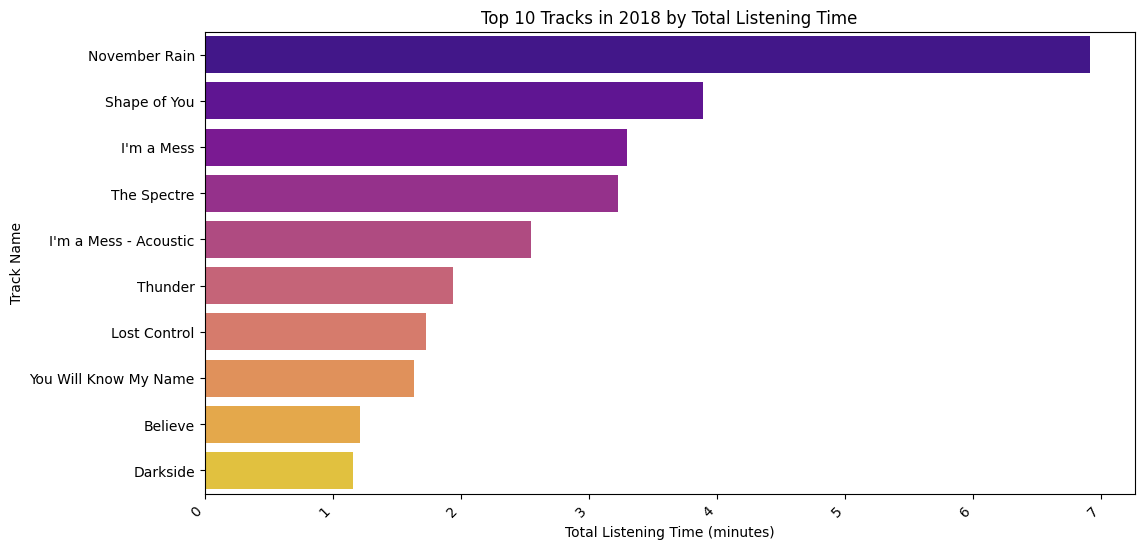

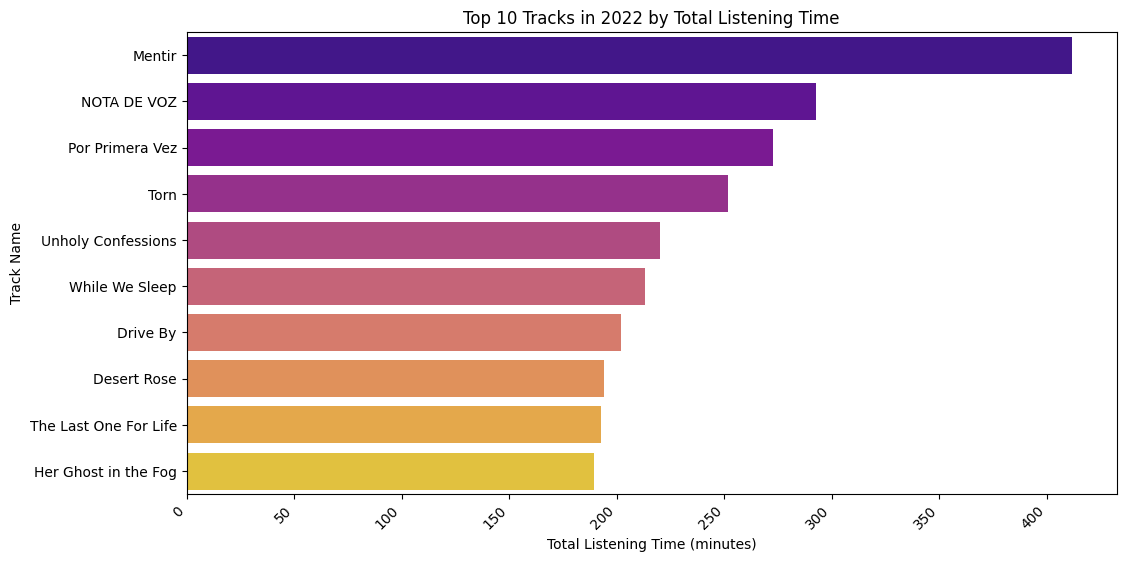

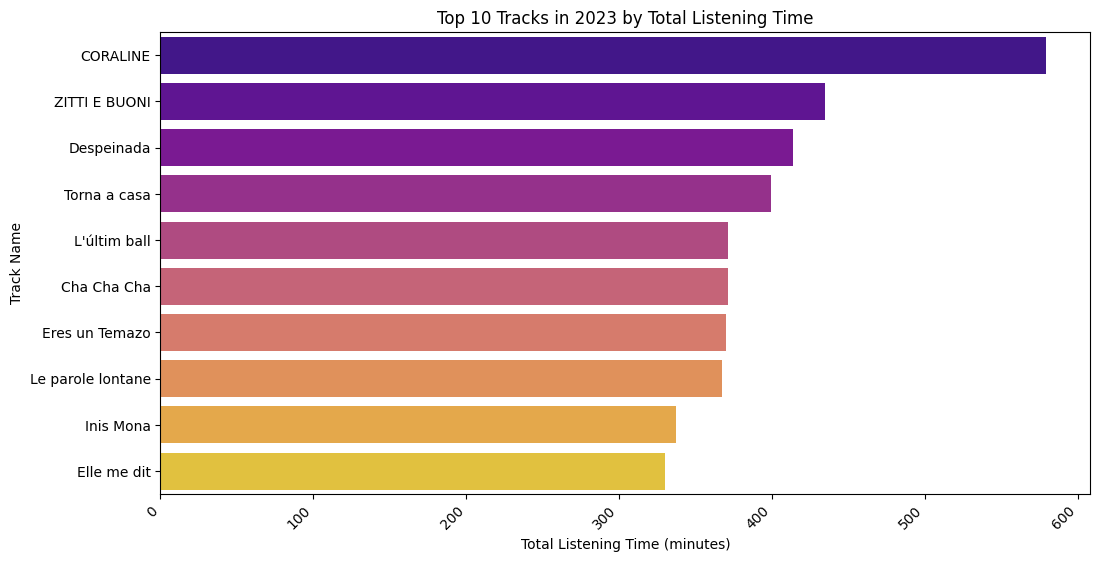

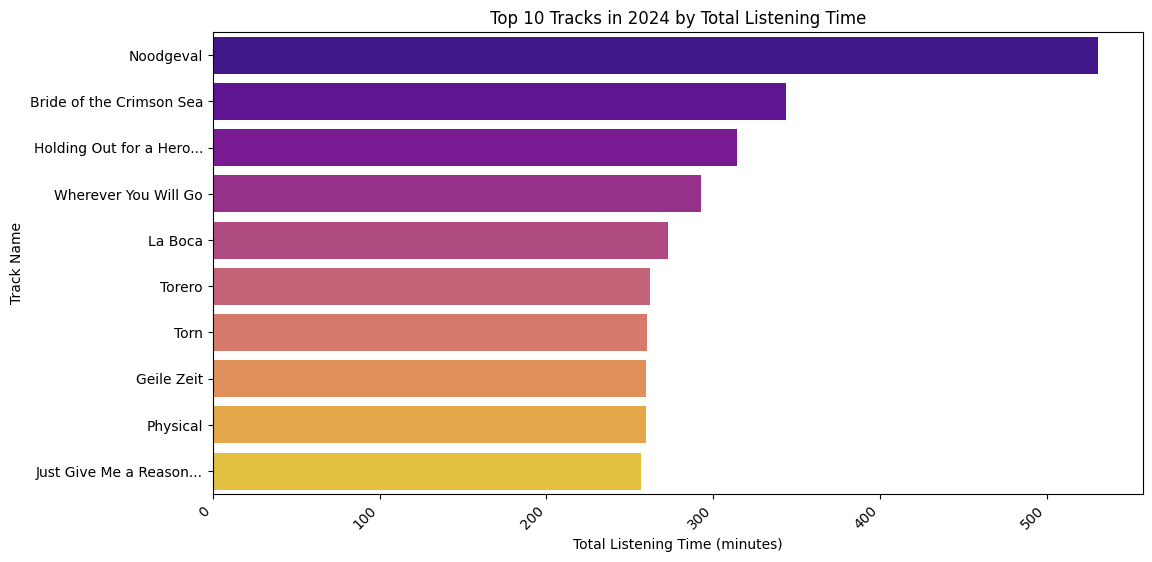

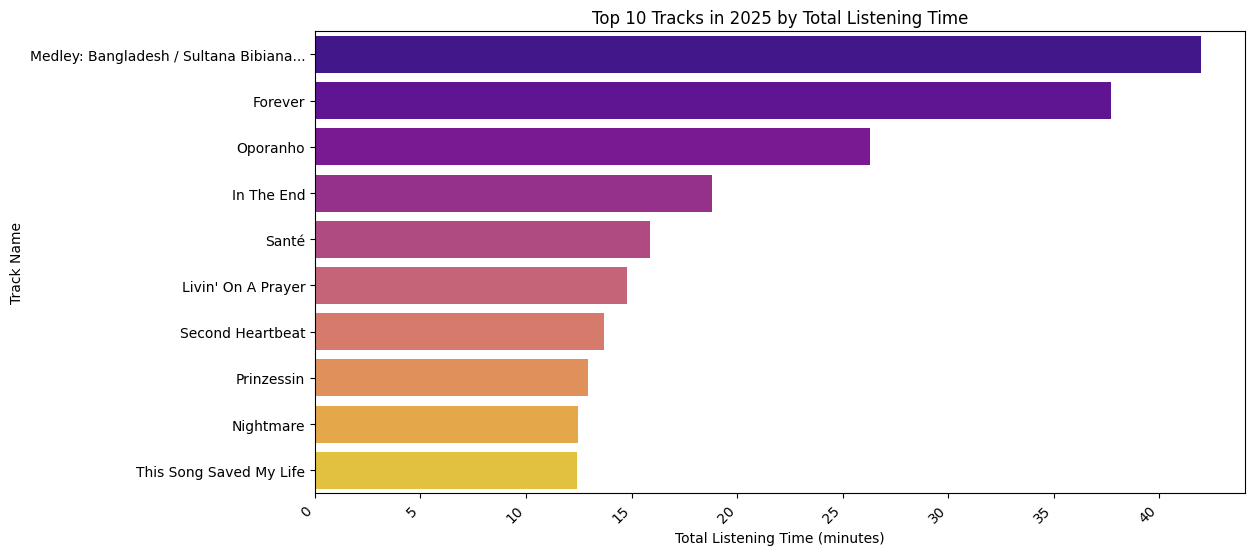

In [9]:
# Group by year and get the top 10 tracks by total listening time
top_10_tracks_each_year = (
    df_audio.groupby(['year', 'master_metadata_track_name'])['minutes_played']
    .sum()
    .reset_index()
    .sort_values(['year', 'minutes_played'], ascending=[True, False])
    .groupby('year')
    .head(10)
)

# Function to shorten track names
def shorten_track_name(name, word_limit=5):
    words = name.split()
    if len(words) > word_limit:
        return ' '.join(words[:word_limit]) + '...'
    return name

# Apply the function to shorten track names
top_10_tracks_each_year['short_track_name'] = top_10_tracks_each_year['master_metadata_track_name'].apply(lambda x: shorten_track_name(x, word_limit=5))

# Plot top 10 tracks for each year separately
years = top_10_tracks_each_year['year'].unique()

for year in years:
    year_data = top_10_tracks_each_year[top_10_tracks_each_year['year'] == year]

    plt.figure(figsize=(12, 6))
    sns.barplot(
        x='minutes_played',
        y='short_track_name',  # Use shortened track names
        data=year_data,
        palette='plasma'
    )
    plt.title(f'Top 10 Tracks in {year} by Total Listening Time')
    plt.xlabel('Total Listening Time (minutes)')
    plt.ylabel('Track Name')
    plt.xticks(rotation=45, ha='right')
    plt.show()


### **Top 20 Tracks of All Time**

This code identifies the 20 most played tracks based on total listening time across all years. It calculates the cumulative listening time for each track, sorts them in descending order, and selects the top 20.

A horizontal bar chart is used to visualize these tracks, showing their total listening time in minutes. This provides a clear view of my all-time favorite tracks and highlights the ones I’ve listened to the most.

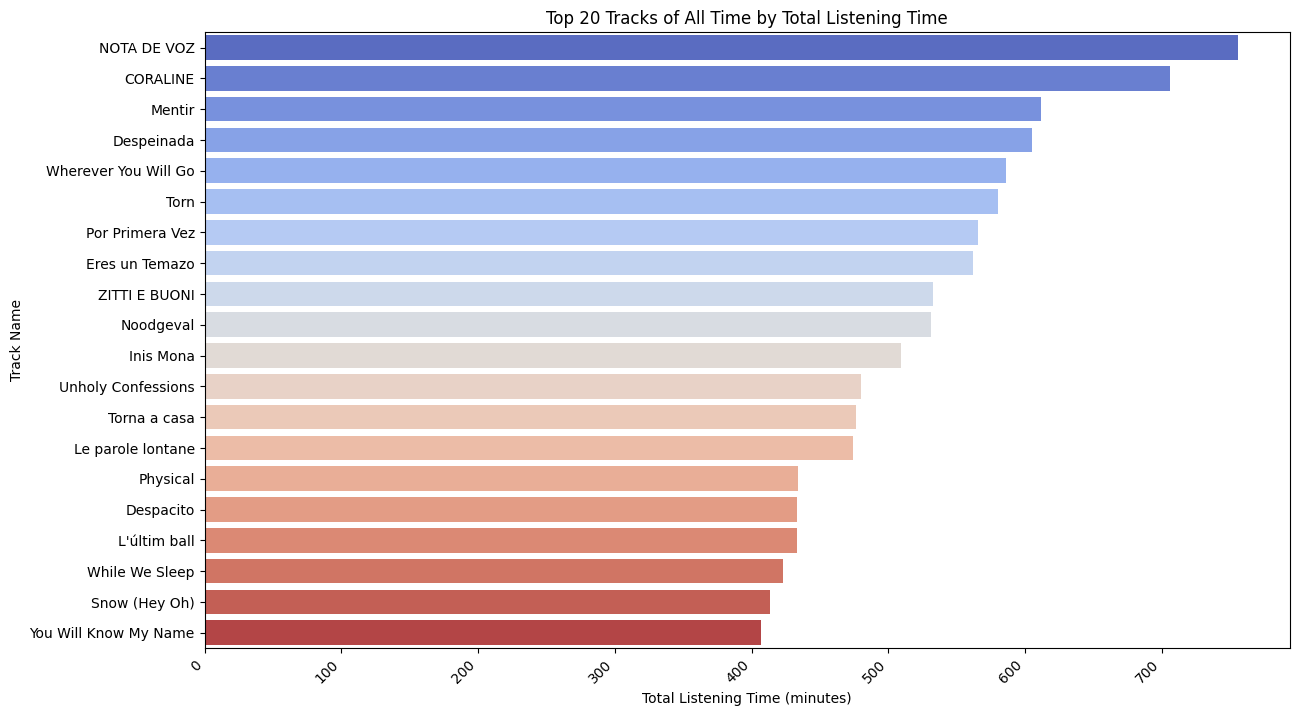

In [10]:
# Top 20 tracks of all time (using minutes_played)
top_20_tracks_all_time = (
    df_audio.groupby('master_metadata_track_name')['minutes_played']
    .sum()
    .sort_values(ascending=False)
    .head(20)
    .reset_index()
)

# Plot top 20 tracks of all time
plt.figure(figsize=(14, 8))
sns.barplot(
    x='minutes_played',
    y='master_metadata_track_name',
    data=top_20_tracks_all_time,
    palette='coolwarm'
)
plt.title('Top 20 Tracks of All Time by Total Listening Time')
plt.xlabel('Total Listening Time (minutes)')
plt.ylabel('Track Name')
plt.xticks(rotation=45, ha='right')
plt.show()


### **Top 10 Artists Each Year**

This code identifies the top 10 most listened-to artists for each year by calculating the total listening time in minutes. It groups the data by year and artist name, aggregates the total listening time, and selects the top 10 artists for each year.

For each year, a horizontal bar chart is generated to visualize the top 10 artists and their corresponding listening times. These charts provide an annual breakdown of my favorite artists, highlighting the ones that defined my music habits year by year.

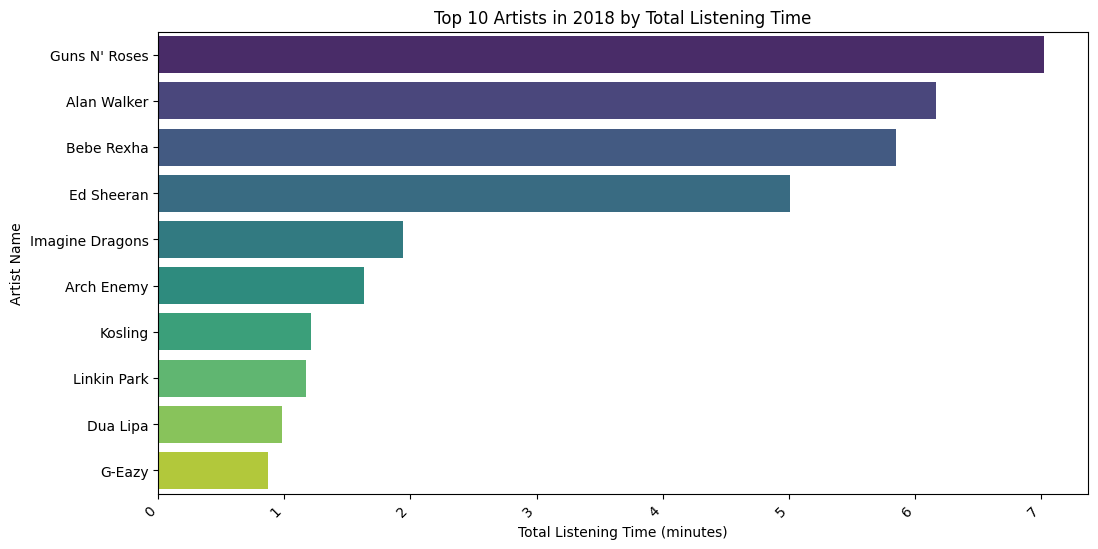

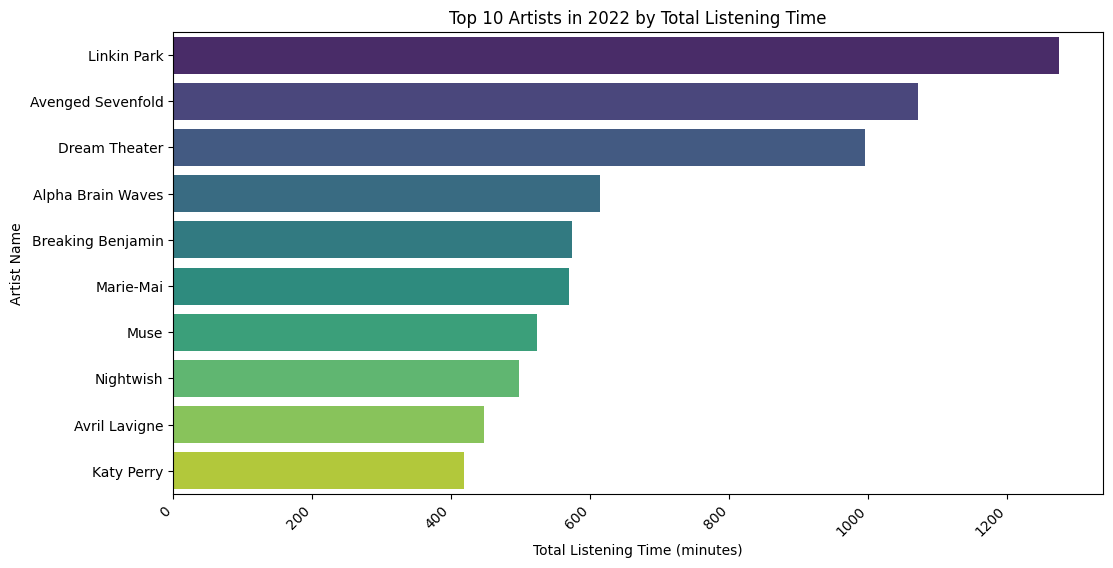

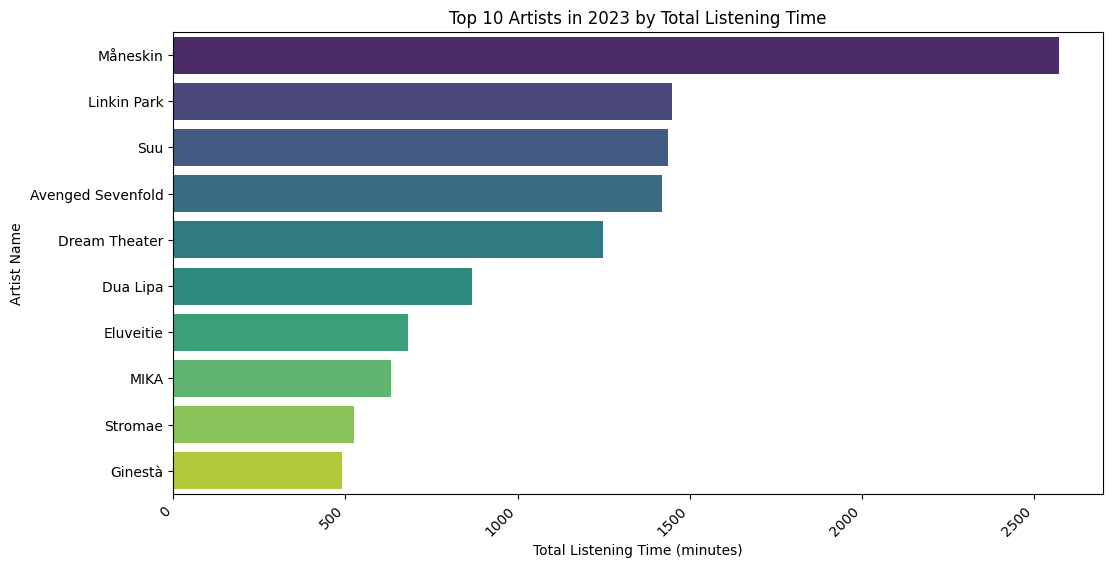

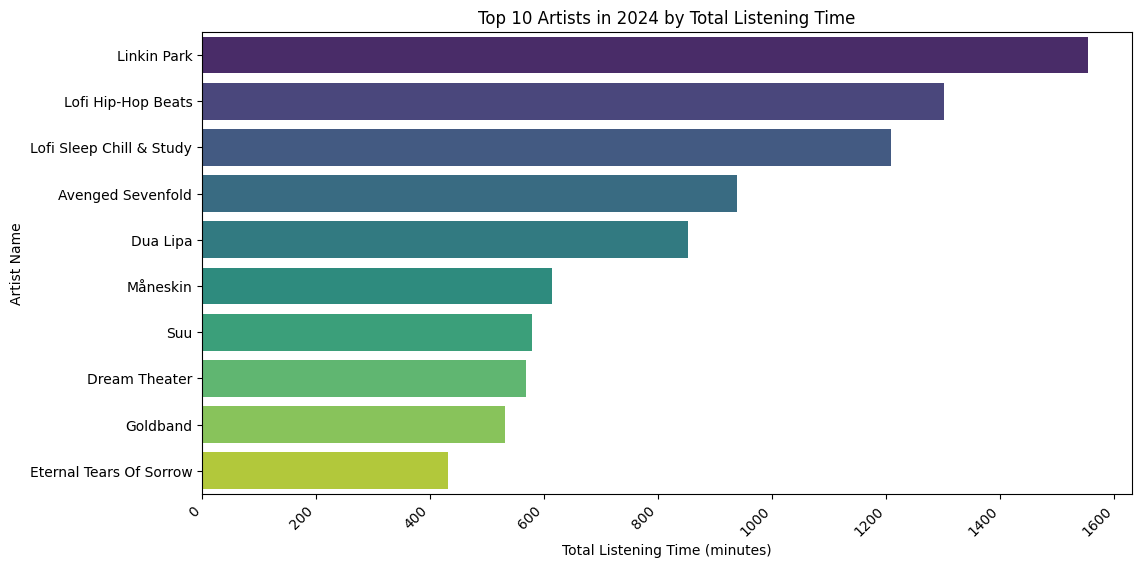

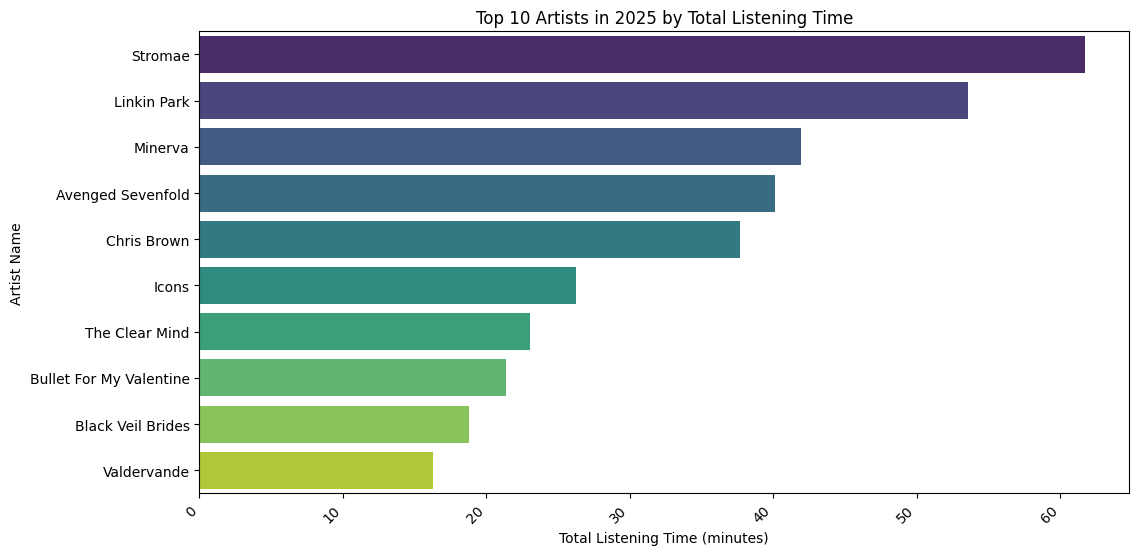

In [11]:
# Top 10 artists for each year (using minutes_played)
top_10_artists_each_year = (
    df_audio.groupby(['year', 'master_metadata_album_artist_name'])['minutes_played']
    .sum()
    .reset_index()
    .sort_values(['year', 'minutes_played'], ascending=[True, False])
    .groupby('year')
    .head(10)  # Get the top 10 artists per year
)

# Plot top 10 artists for each year separately
years = top_10_artists_each_year['year'].unique()

for year in years:
    year_data = top_10_artists_each_year[top_10_artists_each_year['year'] == year]

    plt.figure(figsize=(12, 6))
    sns.barplot(
        x='minutes_played',
        y='master_metadata_album_artist_name',
        data=year_data,
        palette='viridis'
    )
    plt.title(f'Top 10 Artists in {year} by Total Listening Time')
    plt.xlabel('Total Listening Time (minutes)')
    plt.ylabel('Artist Name')
    plt.xticks(rotation=45, ha='right')
    plt.show()


### **Top 20 Artists of All Time**

This code calculates the total listening time for each artist across all years and identifies the top 20 artists with the highest cumulative minutes played.

A horizontal bar chart is used to visualize these artists and their listening times, offering a clear view of my all-time favorite artists. This provides valuable insights into the artists that have consistently defined my music preferences over time.

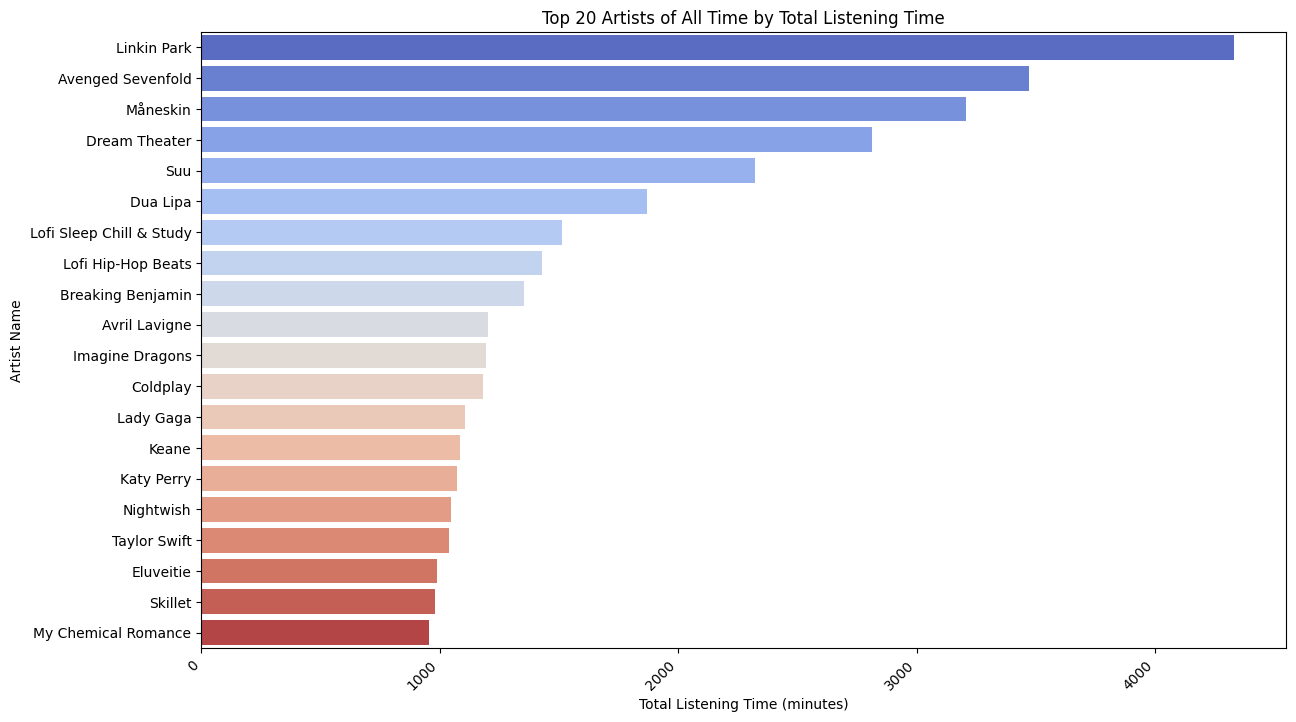

In [12]:
# Top 20 artists of all time (using minutes_played)
top_20_artists_all_time = (
    df_audio.groupby('master_metadata_album_artist_name')['minutes_played']
    .sum()
    .sort_values(ascending=False)
    .head(20)
    .reset_index()
)

# Plot top 20 artists of all time
plt.figure(figsize=(14, 8))
sns.barplot(
    x='minutes_played',
    y='master_metadata_album_artist_name',
    data=top_20_artists_all_time,
    palette='coolwarm'
)
plt.title('Top 20 Artists of All Time by Total Listening Time')
plt.xlabel('Total Listening Time (minutes)')
plt.ylabel('Artist Name')
plt.xticks(rotation=45, ha='right')
plt.show()

### **Total Listening Time Per Year**

This code calculates the total listening time in minutes for each year by aggregating the `minutes_played` across all tracks.

A bar chart is created to visualize the total listening time for each year. This provides a clear overview of my yearly listening habits, highlighting trends such as years with the most or least music consumption. The visualization helps identify patterns or shifts in my listening behavior over time.

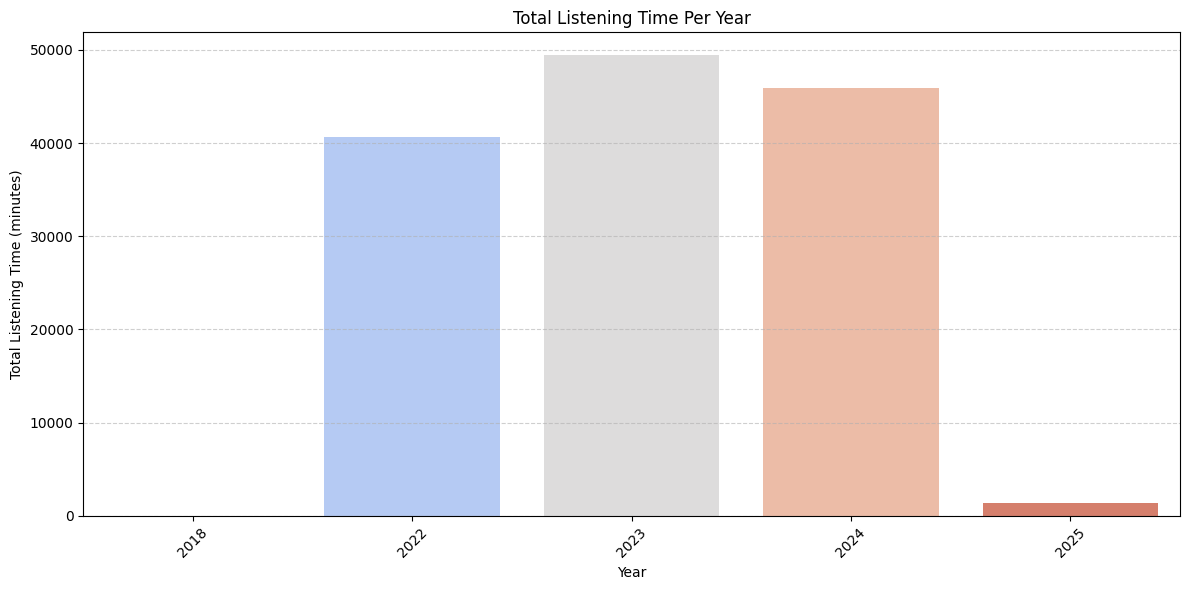

In [13]:
# Calculate total listening time for each year
yearly_listening_time = df_audio.groupby('year')['minutes_played'].sum().reset_index()

# Plot total listening time per year
plt.figure(figsize=(12, 6))
sns.barplot(
    x='year',
    y='minutes_played',
    data=yearly_listening_time,
    palette='coolwarm'
)
plt.title('Total Listening Time Per Year')
plt.xlabel('Year')
plt.ylabel('Total Listening Time (minutes)')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

### **Total Listening Time by Day of the Week**

This code calculates the total listening time for each day of the week by aggregating the `minutes_played` from the audio data. The days are reordered to follow the standard weekly sequence (Monday to Sunday) for better readability.

A bar chart visualizes the total listening time for each day, providing insights into my weekly listening patterns. This helps identify trends, such as whether I listen to more music on weekends, weekdays, or specific days of the week.

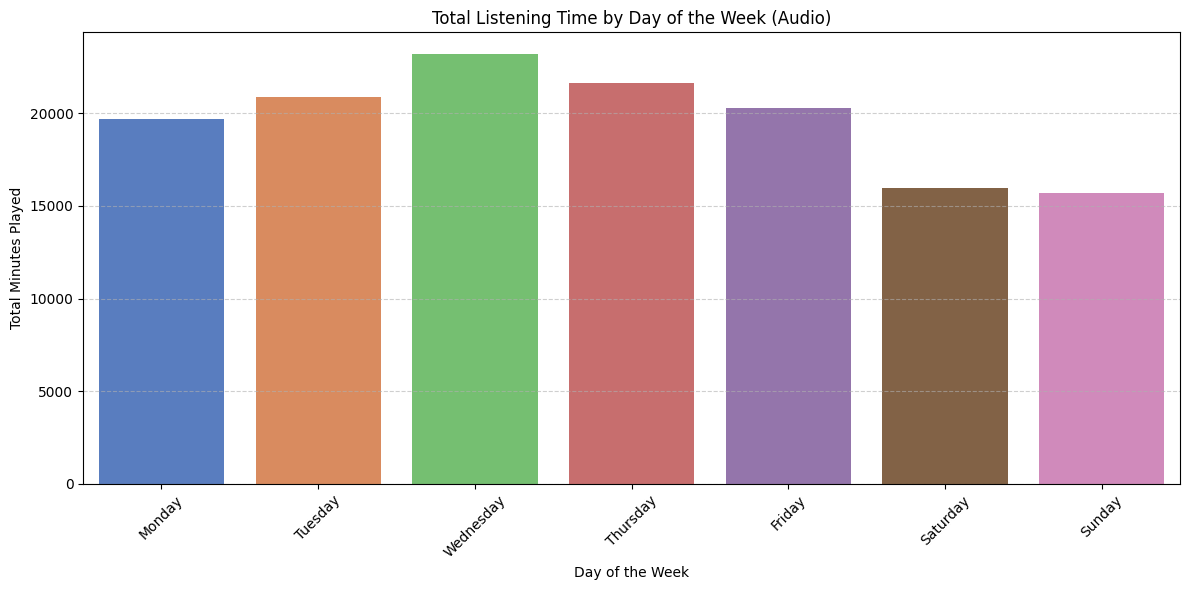

In [14]:
# Calculate total listening time by day of the week
weekly_listening_audio = (
    df_audio.groupby('day_of_week')['minutes_played']
    .sum()
    .reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])  # Ensure proper order
)

# Visualization: Listening time by day of the week
plt.figure(figsize=(12, 6))
sns.barplot(x=weekly_listening_audio.index, y=weekly_listening_audio.values, palette='muted')
plt.title('Total Listening Time by Day of the Week (Audio)')
plt.ylabel('Total Minutes Played')
plt.xlabel('Day of the Week')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


### **Total Listening Time by Hour of the Day**

This code calculates the total listening time for each hour of the day by aggregating the `minutes_played` data from the audio streaming dataset. It converts timestamps (`ts`) to datetime format, extracts the hour information, and groups the data by hour to compute total listening time.

A bar chart is used to visualize the listening patterns across 24 hours, showing the distribution of music consumption throughout the day. This provides insights into my daily listening habits, such as peak listening hours or times when I listen the least.

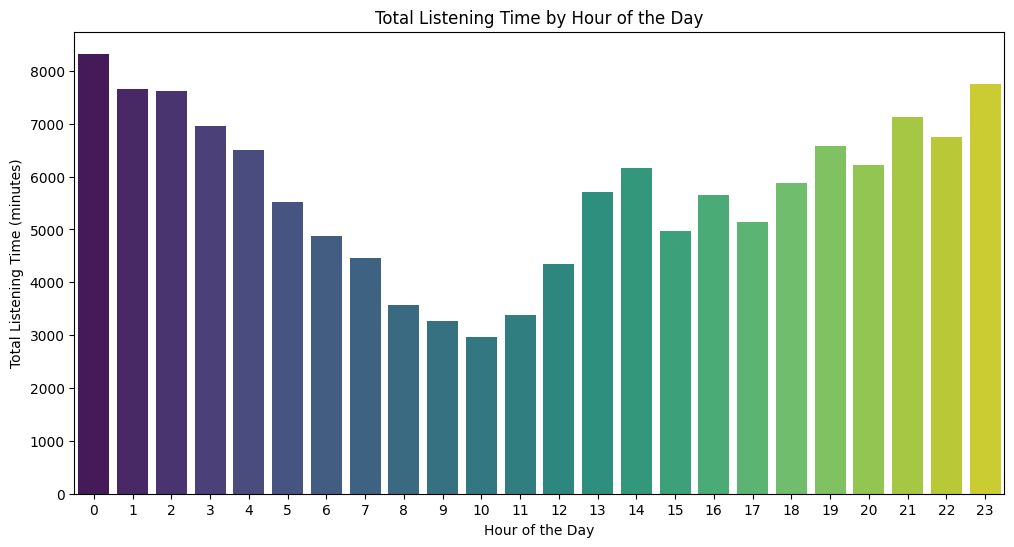

In [15]:
# Convert 'ts' to datetime and extract day of the week and hour
df_audio['datetime'] = pd.to_datetime(df_audio['ts'])
df_audio['day_of_week'] = df_audio['datetime'].dt.day_name()
df_audio['hour'] = df_audio['datetime'].dt.hour
df_audio['minutes_played'] = df_audio['ms_played'] / 60000  # Convert ms to minutes

# Group by hour of the day
hourly_listening = (
    df_audio.groupby('hour')['minutes_played']
    .sum()
    .sort_index()
)

# Plot listening by hour of the day
plt.figure(figsize=(12, 6))
sns.barplot(x=hourly_listening.index, y=hourly_listening.values, palette='viridis')
plt.title('Total Listening Time by Hour of the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Total Listening Time (minutes)')
plt.xticks(range(0, 24))
plt.show()


### **Analyzing Listening Diversity Through Top Artists**

This code examines how much of my total listening time is concentrated among my top 5 most-played artists. By calculating the percentage of listening time from these artists, it provides insights into how diverse my music preferences are.

---

### **Purpose of This Analysis**
For some people, the top 5 or top 20 artists may account for a significant portion (e.g., 60%) of their total listening time, which indicates that their listening habits are more focused or narrow. However, in my case, my top 5 artists account for only **11.91%** of my total listening time.

This suggests:
1. **Diversity**: My music taste is highly diverse, as my listening is spread across many different artists rather than being dominated by just a few.
2. **Exploration**: I likely explore a wide range of genres and artists, rather than sticking to the same set of favorites.

---

### **Why This is Important**
Understanding how much listening time is concentrated among a small group of artists can reveal personal listening behavior:
- **Highly Concentrated (e.g., 60%)**: Indicates loyalty to specific artists or genres.
- **Spread Out (e.g., 11.91%)**: Suggests a more exploratory or eclectic music taste.

This metric helps contextualize my listening habits and provides a useful perspective on how I consume music. It’s also an essential step for building a recommendation system that reflects my unique preferences.

In [26]:
# Calculate total listening time for each artist
artist_listening_time = df_audio.groupby('master_metadata_album_artist_name')['ms_played'].sum()

# Identify top 5 artists
top_5_artists = artist_listening_time.sort_values(ascending=False).head(5)

# Calculate total listening time from top 5 artists
top_5_total_time = top_5_artists.sum()

# Calculate total listening time across all artists
total_listening_time = artist_listening_time.sum()

# Calculate the percentage of total listening time from top 5 artists
percentage_top_5 = (top_5_total_time / total_listening_time) * 100

#print("Top 5 Artists by Total Listening Time:")
#print(top_5_artists / 60000)  # Convert to minutes for readability
print(f"\nPercentage of Total Listening Time from Top 5 Artists: {percentage_top_5:.2f}%")



Percentage of Total Listening Time from Top 5 Artists: 11.91%


### **Cumulative Percentage of Listening Time by Artists**

This code calculates how much each artist contributes to my total listening time and visualizes the cumulative percentage across all artists.

---

### **Purpose of This Analysis**
This analysis helps me understand the distribution of my listening time among all artists:
1. **Artist Contribution**: It calculates the percentage of listening time for each artist and sorts them in descending order.
2. **Cumulative Percentage**: The cumulative percentage shows how quickly the listening time adds up across ranked artists.

---

### **Insights from the Visualization**
- **Cumulative Curve**: The line plot shows how many artists contribute to specific thresholds of my total listening time (e.g., 50%, 90%).
- **50% Threshold**: Indicates the number of top-ranked artists required to account for half of my listening time.
- **90% Threshold**: Highlights the broader range of artists that make up the vast majority of my listening time.

---



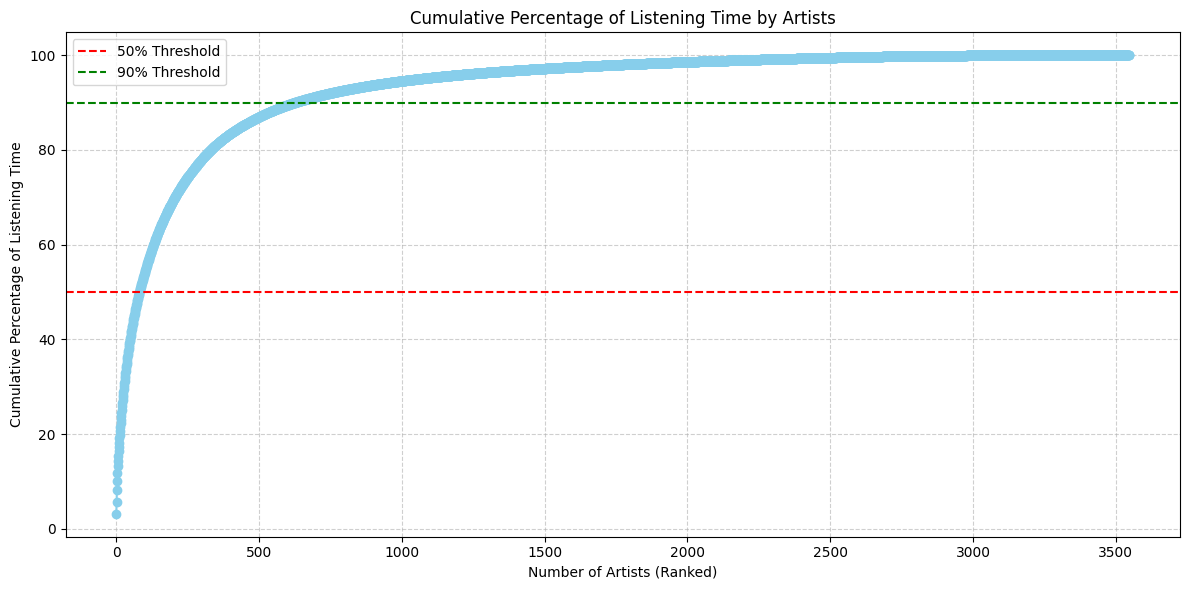

In [27]:
# Calculate percentage contribution of each artist
artist_listening_time_minutes = artist_listening_time / 60000  # Convert ms to minutes
artist_percentage = (artist_listening_time_minutes / artist_listening_time_minutes.sum()) * 100

# Cumulative percentage
cumulative_percentage = artist_percentage.sort_values(ascending=False).cumsum()

# Plot cumulative percentage
plt.figure(figsize=(12, 6))
plt.plot(range(1, len(cumulative_percentage) + 1), cumulative_percentage.values, marker='o', color='skyblue')
plt.axhline(y=50, color='red', linestyle='--', label='50% Threshold')
plt.axhline(y=90, color='green', linestyle='--', label='90% Threshold')
plt.title('Cumulative Percentage of Listening Time by Artists')
plt.xlabel('Number of Artists (Ranked)')
plt.ylabel('Cumulative Percentage of Listening Time')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

### **What This Says About My Listening Habits**
Since my curve rises quickly, it means that a small number of artists dominate my listening habits. This suggests that my music taste is more focused, with the majority of my listening time concentrated among a few favorite artists. This analysis highlights that I tend to stick to a core group of artists, which reflects a more consistent and loyal listening pattern rather than exploring a wide variety of artists.

### **Now nderstanding the Gini Coefficient**

This code calculates the **Gini coefficient** for artist listening time, a statistical measure of inequality.

---

### **What My Gini Coefficient Means**
- **Output: 0.87**:
  - A Gini coefficient of 0 represents perfect equality (every artist contributes equally to listening time).
  - A Gini coefficient of 1 represents perfect inequality (one artist accounts for all listening time).
  - My Gini coefficient of **0.87** indicates **high inequality**, meaning a small number of artists dominate most of my listening time.

---

### **Implications of My Gini Coefficient**
- **Focused Preferences**: The high Gini coefficient suggests that I have a relatively narrow set of favorite artists that receive most of my attention.
- **Consistency**: This indicates a loyal listening pattern, where I spend the majority of my time with a few preferred artists rather than exploring a wide variety.
- **Personal Insight**: This analysis provides a clear metric to understand the concentration of my listening habits and highlights my strong preferences for specific artists.

In [28]:
def gini_coefficient(values):
    sorted_values = np.sort(values)  # Sort values in ascending order
    cumulative_values = np.cumsum(sorted_values) / sum(sorted_values)
    lorenz_curve = np.insert(cumulative_values, 0, 0)  # Add a zero at the start
    n = len(lorenz_curve)
    gini = (1 - 2 * np.sum(lorenz_curve) / n)
    return gini

gini = gini_coefficient(artist_listening_time.values)
print(f"Gini Coefficient for Artist Listening Time: {gini:.2f}")

Gini Coefficient for Artist Listening Time: 0.87


### **Session-Based Listening Analysis**

This step segments the listening data into individual sessions based on a defined time gap between consecutive plays. By calculating the average listening time per session, it provides valuable insights into my engagement patterns.

The design choice of using a 10-minute session gap reflects a reasonable assumption of inactivity between sessions, allowing for an accurate grouping of continuous listening periods. This analysis helps uncover how long I typically listen in one sitting and provides a clearer understanding of my listening behavior beyond cumulative totals.

In [29]:
# Convert 'ts' to datetime
df_audio['datetime'] = pd.to_datetime(df_audio['ts'])

# Sort the data by user and timestamp (if user-specific data exists)
df_audio = df_audio.sort_values(by='datetime').reset_index(drop=True)

# Define a session gap threshold (e.g., 30 minutes)
session_gap = pd.Timedelta(minutes=10)

# Calculate the time difference between consecutive rows
df_audio['time_diff'] = df_audio['datetime'].diff()

# Start a new session whenever the time difference exceeds the session gap
df_audio['session_id'] = (df_audio['time_diff'] > session_gap).cumsum()

# Calculate total listening time per session
session_listening_time = df_audio.groupby('session_id')['ms_played'].sum()

# Convert to minutes
session_listening_time_minutes = session_listening_time / 60000

# Calculate the average listening time per session
average_listening_time_per_session = session_listening_time_minutes.mean()

print(f"Average Listening Time Per Session: {average_listening_time_per_session:.2f} minutes")


Average Listening Time Per Session: 24.23 minutes


### **Analyzing Skipped Tracks**

This step focuses on identifying the most frequently skipped tracks and understanding potential reasons for skipping. It provides insights into songs that might not resonate well with my preferences or listening context.

---

### **What This Analysis Does**

1. **Top 10 Skipped Tracks**:
   - The tracks with the highest number of skips are identified and ranked. These represent the songs I most often chose to skip, possibly indicating a lack of interest or mismatch with my mood.

2. **Reasons for Skipping**:
   - The reasons for skipping (e.g., "user_end", "track_error") are analyzed to understand whether skips were intentional or due to external factors, such as playback issues.

3. **Visualization**:
   - A horizontal bar chart displays the top 10 skipped tracks, showing the number of times each track was skipped. This helps highlight tracks that consistently fail to engage me.

---

### **Why This is Important**
- **Personal Insights**: Understanding which tracks I frequently skip helps refine my playlists by avoiding these songs in the future.
- **Playlist Optimization**: If skips are linked to specific genres or artists, it can guide the curation of playlists to better match my preferences.
- **Behavioral Patterns**: Analyzing skip reasons provides deeper insights into whether skips are mood-driven, context-specific, or due to technical issues.

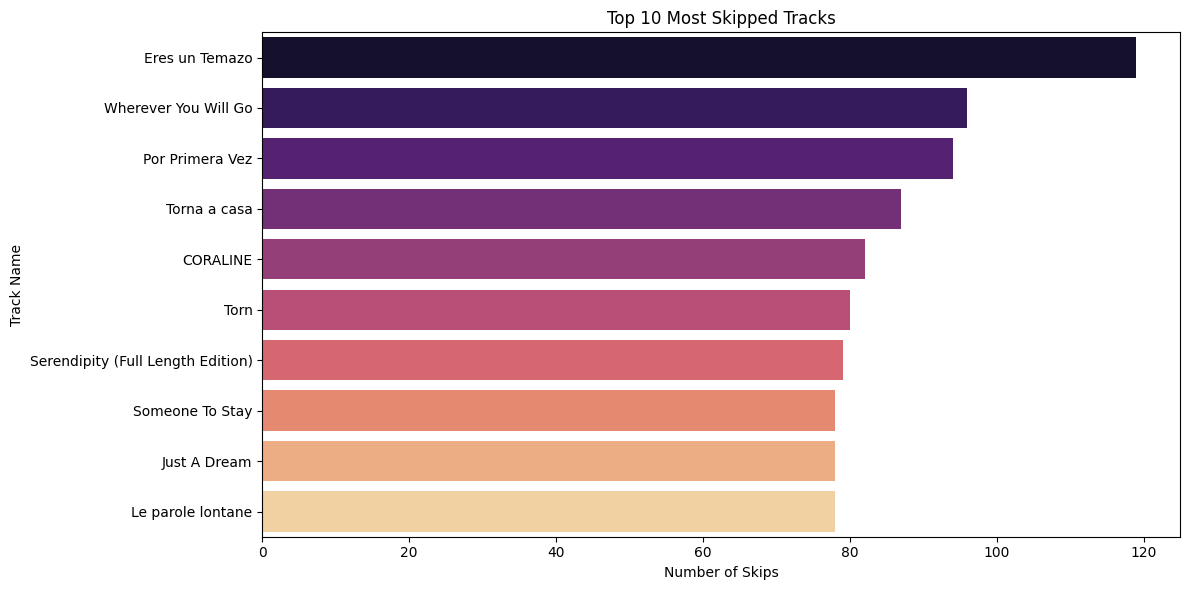

In [30]:
# Calculate total skip counts for each track
skipped_tracks = df_audio[df_audio['skipped'] == True]  # Filter skipped tracks
track_skip_counts = skipped_tracks['master_metadata_track_name'].value_counts().head(10)

# Analyze reasons for skipping
skip_reasons = skipped_tracks['reason_end'].value_counts()

# Visualization: Top 10 skipped tracks
plt.figure(figsize=(12, 6))
sns.barplot(x=track_skip_counts.values, y=track_skip_counts.index, palette='magma')
plt.title('Top 10 Most Skipped Tracks')
plt.xlabel('Number of Skips')
plt.ylabel('Track Name')
plt.tight_layout()
plt.show()

### **Analyzing Replayed Tracks**

This step identifies the tracks I replay most often and visualizes the top 10 replayed songs. Replaying a track indicates strong personal engagement or a deep connection to the song.

---

### **What This Analysis Shows**

1. **Top 10 Replayed Tracks**:
   - Tracks restarted due to "trackdone" (indicating a replay) are filtered and ranked by the number of replays. These tracks represent songs that I enjoy so much that I often replay them immediately after they finish.

2. **Visualization**:
   - A horizontal bar chart highlights the top 10 replayed tracks along with their replay counts. This provides a clear view of my most engaging and replay-worthy songs.

---

### **Why This is Important**
- **Personal Favorites**: Identifying replayed tracks offers insights into my most cherished songs.
- **Strong Preferences**: Tracks with frequent replays may indicate deeper emotional or nostalgic value, making them essential to include in personalized playlists.
- **Engagement Patterns**: This analysis helps understand which tracks resonate strongly and could guide the design of a recommendation system to emphasize similar songs.

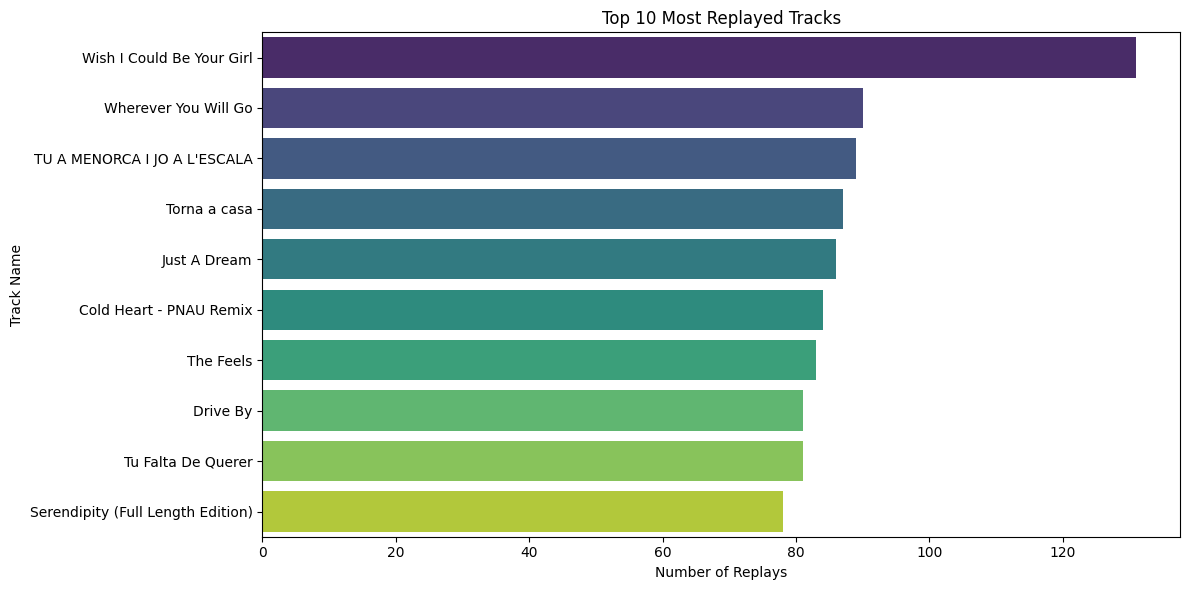

In [31]:
# Filter for tracks restarted due to "trackdone" (indicates a replay)
replayed_tracks = df_audio[df_audio['reason_start'] == 'trackdone']

# Calculate the number of replays for each track
track_replay_counts = replayed_tracks['master_metadata_track_name'].value_counts().head(10)

# Visualization: Top 10 replayed tracks
plt.figure(figsize=(12, 6))
sns.barplot(x=track_replay_counts.values, y=track_replay_counts.index, palette='viridis')
plt.title('Top 10 Most Replayed Tracks')
plt.xlabel('Number of Replays')
plt.ylabel('Track Name')
plt.tight_layout()
plt.show()


### **Sourcing Data for Recommendation System**

With Spotify discontinuing API access for retrieving song features, I faced a challenge in obtaining the data necessary to build a recommendation system. To address this, I searched for reliable third-party datasets that could fill this gap. After careful consideration, I chose four datasets, each contributing unique aspects of song information. Here's why these datasets were selected:

---

### **Datasets Used and Their Purpose**

1. **Spotify 12M Songs Dataset (`path_a`)**:
   - This extensive dataset contains over 12 million songs, providing a rich source of song metadata, such as track names and artists.
   - It ensures that the dataset is broad enough to include a variety of genres, artists, and tracks.

2. **Spotify Tracks Genre Dataset (`path_b`)**:
   - This dataset focuses on genre classification, offering valuable insights into the style and mood of songs.
   - Genre data is essential for tailoring recommendations to a user’s preferences and ensuring diverse suggestions.

3. **Spotify Audio Features Dataset (`path_c`)**:
   - Contains detailed audio features such as danceability, energy, acousticness, and valence.
   - These attributes are critical for creating a recommendation system that aligns with listening habits and preferences, even without direct access to Spotify's original API.

4. **Spotify Dataset (1921–2020, 600k Tracks) (`path_d`)**:
   - Offers a historical perspective on music trends and includes a large selection of tracks with detailed metadata.
   - This dataset helps capture both contemporary hits and timeless classics, adding depth to the recommendation system.

---

### **Why Combine These Datasets?**
- **Completeness**: By combining these datasets, I can leverage metadata, genres, and audio features to create a well-rounded recommendation system.
- **Reliability**: Each dataset complements the others, filling in gaps where one dataset may lack specific details.
- **Diversity**: With millions of tracks spanning various time periods and genres, the combined data ensures that recommendations cater to a wide range of tastes and moods.

---

### **Key Takeaway**
The decision to combine these datasets ensures that the recommendation system is robust and comprehensive, despite the loss of Spotify's API. By integrating metadata, audio features, and genre classifications, I can create a highly personalized and accurate recommendation engine.

In [53]:
# Download latest version
path_a = kagglehub.dataset_download("rodolfofigueroa/spotify-12m-songs")
path_b = kagglehub.dataset_download("thedevastator/spotify-tracks-genre-dataset")
path_c = kagglehub.dataset_download("tomigelo/spotify-audio-features")
path_d = kagglehub.dataset_download("yamaerenay/spotify-dataset-19212020-600k-tracks")

print("Path to dataset files:", path_a)
print("Path to dataset files:", path_b)
print("Path to dataset files:", path_c)
print("Path to dataset files:", path_d)

Path to dataset files: /root/.cache/kagglehub/datasets/rodolfofigueroa/spotify-12m-songs/versions/1
Path to dataset files: /root/.cache/kagglehub/datasets/thedevastator/spotify-tracks-genre-dataset/versions/1
Path to dataset files: /root/.cache/kagglehub/datasets/tomigelo/spotify-audio-features/versions/3
Path to dataset files: /root/.cache/kagglehub/datasets/yamaerenay/spotify-dataset-19212020-600k-tracks/versions/1


### **Loading the Datasets**

This code loads four datasets from their respective file paths, creating DataFrames for each:

1. **Tracks with Features**: Contains detailed track information and features from the Spotify 12M Songs Dataset.
2. **Genre Classification**: Provides track-to-genre mappings, useful for understanding the style and mood of songs.
3. **Audio Features**: Includes detailed song-level audio features like danceability, energy, and valence.
4. **Metadata and Historical Data**: Offers a broad historical perspective on tracks spanning from 1921 to 2020.

These datasets are now ready for preprocessing and integration into the recommendation system.

In [54]:
dataset_path_a = "/root/.cache/kagglehub/datasets/rodolfofigueroa/spotify-12m-songs/versions/1"
dataset_path_b = "/root/.cache/kagglehub/datasets/thedevastator/spotify-tracks-genre-dataset/versions/1"
dataset_path_c = "/root/.cache/kagglehub/datasets/tomigelo/spotify-audio-features/versions/3"
dataset_path_d = "/root/.cache/kagglehub/datasets/yamaerenay/spotify-dataset-19212020-600k-tracks/versions/1"

csv_file_1 = os.path.join(dataset_path_a, 'tracks_features.csv')
csv_file_2 = os.path.join(dataset_path_b, 'train.csv')
csv_file_3 = os.path.join(dataset_path_c, 'SpotifyAudioFeaturesApril2019.csv')
csv_file_4 = os.path.join(dataset_path_d, 'tracks.csv')


# Load the dataset
df_kaggle = pd.read_csv(csv_file_1)
df_kaggle_2 = pd.read_csv(csv_file_2)
df_kaggle_3 = pd.read_csv(csv_file_3)
df_kaggle_4 = pd.read_csv(csv_file_4)

### **Combining Datasets for Comprehensive Analysis**

This step integrates audio feature data from multiple datasets into two distinct outputs:

1. **Dataset with Only Audio Features**:
   - Focuses solely on audio feature columns like `danceability`, `energy`, and `valence`.
   - This dataset is useful for tasks that rely purely on numerical analysis of song characteristics, such as clustering or machine learning models.
   - Duplicates are removed to ensure unique rows.

2. **Dataset with Track and Artist Metadata**:
   - Includes `track_name` and `artist_name` alongside audio features, offering a more descriptive dataset.
   - Standardized column names across all datasets ensure consistency for seamless integration.
   - Duplicates are removed to avoid redundancy.

Both datasets are saved separately, providing flexibility for future analyses. The dataset with names (`spotify_audio_features_combined_with_names.csv`) is ideal for tasks requiring human-readable track and artist metadata, while the audio-only dataset (`spotify_audio_features_combined.csv`) is optimized for feature-based computational analysis.

In [63]:
# Define audio features columns
audio_features_columns = [
    'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
    'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
    'duration_ms', 'time_signature'
]

# Step 1: Combine datasets using only audio features columns
audio_features_only_df = pd.concat([
    df_kaggle[audio_features_columns],
    df_kaggle_2[audio_features_columns],
    df_kaggle_3[audio_features_columns],
    df_kaggle_4[audio_features_columns]
], ignore_index=True)

# Remove duplicate rows
audio_features_only_df = audio_features_only_df.drop_duplicates()

# Save the dataset with only audio features
print("Rows in audio features only dataset:", len(audio_features_only_df))

# Step 2: Select relevant columns including track and artist names
df_kaggle = df_kaggle[['track_name', 'artist_name'] + audio_features_columns]
df_kaggle_2 = df_kaggle_2[['track_name', 'artist_name'] + audio_features_columns]
df_kaggle_3 = df_kaggle_3[['track_name', 'artist_name'] + audio_features_columns]
df_kaggle_4 = df_kaggle_4[['track_name', 'artist_name'] + audio_features_columns]

# Rename columns to have consistent naming conventions
df_kaggle.rename(columns={'name': 'track_name', 'artists': 'artist_name'}, inplace=True)
df_kaggle_2.rename(columns={'track_name': 'track_name', 'artists': 'artist_name'}, inplace=True)
df_kaggle_3.rename(columns={'track_name': 'track_name', 'artist_name': 'artist_name'}, inplace=True)
df_kaggle_4.rename(columns={'name': 'track_name', 'artists': 'artist_name'}, inplace=True)

# Combine all datasets vertically, including track and artist names
combined_df = pd.concat([df_kaggle, df_kaggle_2, df_kaggle_3, df_kaggle_4], ignore_index=True)

# Remove duplicate rows
combined_df = combined_df.drop_duplicates()

# Save the final combined dataset with track and artist names
combined_df.to_csv("spotify_audio_features_combined.csv", index=False)
print("Rows in combined dataset with names:", len(combined_df))


Rows in audio features only dataset: 1931648
Rows in combined dataset with names: 1958483


In [65]:
combined_df.head()

,track_name,artist_name,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,Testify,['Rage Against The Machine'],0.470,0.978,7,-5.399,1,0.0727,0.02610,0.000011,0.3560,0.503,117.906,210133,4.0
1,Guerrilla Radio,['Rage Against The Machine'],0.599,0.957,11,-5.764,1,0.1880,0.01290,0.000071,0.1550,0.489,103.680,206200,4.0
2,Calm Like a Bomb,['Rage Against The Machine'],0.315,0.970,7,-5.424,1,0.4830,0.02340,0.000002,0.1220,0.370,149.749,298893,4.0
3,Mic Check,['Rage Against The Machine'],0.440,0.967,11,-5.830,0,0.2370,0.16300,0.000004,0.1210,0.574,96.752,213640,4.0
4,Sleep Now In the Fire,['Rage Against The Machine'],0.426,0.929,2,-6.729,1,0.0701,0.00162,0.105000,0.0789,0.539,127.059,205600,4.0


### **Cleaning the metadata**


In [66]:
# Function to clean artist names
def clean_artist_name(text):
    if isinstance(text, str):
        # Remove brackets, quotes, and other unwanted characters
        cleaned = re.sub(r"[\[\]'\"']", "", text)
        # Remove any leading/trailing whitespace
        cleaned = cleaned.strip()
        return cleaned
    return text

# Clean the artist names
combined_df['artist_name'] = combined_df['artist_name'].apply(clean_artist_name)

# Clean the track names as well for consistency
combined_df['track_name'] = combined_df['track_name'].apply(clean_artist_name)

# Display first few rows to verify the cleaning
display(combined_df.head())


,track_name,artist_name,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,Testify,Rage Against The Machine,0.470,0.978,7,-5.399,1,0.0727,0.02610,0.000011,0.3560,0.503,117.906,210133,4.0
1,Guerrilla Radio,Rage Against The Machine,0.599,0.957,11,-5.764,1,0.1880,0.01290,0.000071,0.1550,0.489,103.680,206200,4.0
2,Calm Like a Bomb,Rage Against The Machine,0.315,0.970,7,-5.424,1,0.4830,0.02340,0.000002,0.1220,0.370,149.749,298893,4.0
3,Mic Check,Rage Against The Machine,0.440,0.967,11,-5.830,0,0.2370,0.16300,0.000004,0.1210,0.574,96.752,213640,4.0
4,Sleep Now In the Fire,Rage Against The Machine,0.426,0.929,2,-6.729,1,0.0701,0.00162,0.105000,0.0789,0.539,127.059,205600,4.0


### **Optimized Removal of Similar Duplicates**

This function identifies and removes duplicate tracks that are similar in name and by the same artist, based on a similarity threshold:

1. **Preprocessing**:
   - Converts `track_name` and `artist_name` to lowercase for consistent comparisons.
   - Sorts the dataset by `artist_name` to improve efficiency.

2. **Similarity Check**:
   - For each artist, only compares tracks within the same artist to reduce unnecessary comparisons.
   - Uses the `SequenceMatcher` to compute the similarity between track names (faster than fuzzy matching for large datasets).

3. **Threshold-Based Removal**:
   - Tracks with a similarity ratio of 90% or more (`threshold=0.9`) are flagged as duplicates and removed.

4. **Output**:
   - Returns a cleaned DataFrame with duplicates removed, retaining only unique track names for each artist.

This ensures the dataset is free from highly similar duplicates, improving the quality of the recommendation system.

In [67]:
def drop_similar_duplicates_optimized(df, track_col, artist_col, threshold=0.9):
    # Create a hash map to store unique combinations
    unique_combinations = {}
    indices_to_drop = []

    # Convert to lowercase once for all entries
    df[track_col] = df[track_col].str.lower()
    df[artist_col] = df[artist_col].str.lower()

    # Sort by artist name to improve locality
    df = df.sort_values(artist_col)

    for index, row in df.iterrows():
        track_name = str(row[track_col])
        artist_name = str(row[artist_col])

        # Use artist name as key to reduce comparison space
        if artist_name in unique_combinations:
            # Only compare with tracks from the same artist
            for existing_track, existing_index in unique_combinations[artist_name]:
                # Use SequenceMatcher which is faster than fuzz for large strings
                track_similarity = SequenceMatcher(None, track_name, existing_track).ratio()

                if track_similarity >= threshold:
                    indices_to_drop.append(index)
                    break
            else:
                unique_combinations[artist_name].append((track_name, index))
        else:
            unique_combinations[artist_name] = [(track_name, index)]

    return df.drop(indices_to_drop)

# Apply the optimized function
cleaned_df = drop_similar_duplicates_optimized(combined_df,
                                             track_col='track_name',
                                             artist_col='artist_name',
                                             threshold=0.9)


In [70]:
print(len(cleaned_df))
cleaned_df.to_csv("spotify_audio_features_unique.csv", index=False)

1735185


In [20]:
cleaned_df = pd.read_csv("spotify_audio_features_unique.csv")
print(len(cleaned_df))

1735185


### **Identifying Unique Songs**

This code extracts a list of unique songs based on track name and artist name:

1. **Filtering Unique Songs**:
   - Uses `drop_duplicates` to remove duplicate entries with the same `master_metadata_track_name` and `master_metadata_album_artist_name`.
   - Ensures that only unique combinations of track names and artists are retained.

2. **Additional Information**:
   - Includes the album name (`master_metadata_album_album_name`) for additional context about each track.

3. **Summary Statistics**:
   - Displays the total number of unique songs in the dataset.
   - Provides a preview of the first few unique songs for a quick glance at the cleaned data.

This step helps streamline the dataset by eliminating duplicate tracks, ensuring accurate and non-redundant analysis.

In [21]:
# Find unique songs based on track name and artist name
unique_songs = df_audio.drop_duplicates(
    subset=['master_metadata_track_name', 'master_metadata_album_artist_name']
)[['master_metadata_track_name', 'master_metadata_album_artist_name', 'master_metadata_album_album_name']]

# Display number of unique songs
print(f"Number of unique songs: {len(unique_songs)}")

# Display first few unique songs
display(unique_songs.head())


Number of unique songs: 9080


,master_metadata_track_name,master_metadata_album_artist_name,master_metadata_album_album_name
0,Don't Let Me Down,The Chainsmokers,Don't Let Me Down
1,IDGAF,Dua Lipa,Dua Lipa
2,"Me, Myself & I",G-Eazy,When It's Dark Out
3,Thunder,Imagine Dragons,Evolve
4,Believe,Kosling,Believe


### **Identifying Overlapping Songs**

This code identifies and extracts overlapping songs between two datasets (`df_audio` and `combined_df`) based on track and artist names:

1. **Create Unique Songs from `df_audio`**:
   - Removes duplicates from `df_audio` based on track name and artist name.
   - Retains relevant metadata like album name for additional context.

2. **Standardize for Comparison**:
   - Converts track and artist names to lowercase in both datasets (`unique_songs_df_audio` and `combined_df`) to ensure case-insensitive matching.

3. **Find Overlapping Songs**:
   - Merges the two datasets on the standardized `track_name_lower` and `artist_name_lower` columns.
   - Keeps only unique overlapping entries to ensure no redundant matches.

4. **Summary Statistics**:
   - Displays the number of unique songs in `df_audio`, the size of `combined_df`, and the count of overlapping songs between the two datasets.

This step highlights shared songs across datasets, which can be used for further analysis or validation of the recommendation system.

In [22]:
# First create unique songs dataframe
unique_songs_df_audio = df_audio.drop_duplicates(
    subset=['master_metadata_track_name', 'master_metadata_album_artist_name']
)[['master_metadata_track_name', 'master_metadata_album_artist_name', 'master_metadata_album_album_name']]

# Then proceed with the lowercase comparison
unique_songs_df_audio['track_name_lower'] = unique_songs_df_audio['master_metadata_track_name'].str.lower()
unique_songs_df_audio['artist_name_lower'] = unique_songs_df_audio['master_metadata_album_artist_name'].str.lower()

cleaned_df['track_name_lower'] = cleaned_df['track_name'].str.lower()
cleaned_df['artist_name_lower'] = cleaned_df['artist_name'].str.lower()

# Find overlapping songs and ensure uniqueness
overlapping_songs = pd.merge(
    unique_songs_df_audio,
    cleaned_df,
    left_on=['track_name_lower', 'artist_name_lower'],
    right_on=['track_name_lower', 'artist_name_lower'],
    how='inner'
).drop_duplicates(subset=['track_name_lower', 'artist_name_lower'], keep='first')

# Print statistics
print(f"Number of unique songs in df_audio: {len(unique_songs_df_audio)}")
print(f"Number of songs in combined_df: {len(cleaned_df)}")
print(f"Number of unique overlapping songs: {len(overlapping_songs)}")


Number of unique songs in df_audio: 9080
Number of songs in combined_df: 1735185
Number of unique overlapping songs: 2555


In [26]:
# Normalize text in both DataFrames
def normalize_text(df, track_col, artist_col):
    df[track_col] = df[track_col].str.lower().str.strip()
    df[artist_col] = df[artist_col].str.lower().str.strip()
    return df

cleaned_df = normalize_text(cleaned_df, 'track_name', 'artist_name')
df_audio = normalize_text(df_audio, 'master_metadata_track_name', 'master_metadata_album_artist_name')


### **Deleting unnecessary df**


In [31]:
import gc

# List of DataFrame names to keep
keep_vars = ['cleaned_df', 'overlapping_songs', 'unique_songs', 'unique_songs_df_audio', 'df_audio']

# Get all DataFrame names in the environment
df_names = [var for var in globals() if isinstance(globals()[var], pd.DataFrame)]

# Delete all DataFrames except those in `keep_vars`
for var in df_names:
    if var not in keep_vars:
        del globals()[var]

# Force garbage collection
gc.collect()

print("Remaining DataFrames:")
print([var for var in globals() if isinstance(globals()[var], pd.DataFrame)])


Remaining DataFrames:
['df_audio', 'cleaned_df', 'unique_songs', 'unique_songs_df_audio', 'overlapping_songs']


### **Creating a Personalized Playlist**

This code generates a personalized music playlist by analyzing overlapping songs between two datasets and matching them to my music preferences using audio features. Here's how the process works:

---

### **Concept Behind the Recommendation System**

1. **Identify Overlapping Songs**:
   - By combining my personal listening history (`df_audio`) and a larger, curated dataset (`combined_df`), the system identifies tracks that appear in both datasets. These overlapping songs represent a shared pool of tracks with complete audio feature data, forming the basis for recommendations.

2. **Normalize Audio Features**:
   - Audio features like `danceability`, `energy`, and `valence` are normalized to bring all feature values to a comparable scale. This step ensures that no single feature disproportionately affects the recommendation process.

3. **Understand User Preferences**:
   - A **user taste profile** is created by calculating the average similarity of audio features across all overlapping songs in my listening history. This profile represents my general music preferences based on the songs I’ve already enjoyed.

4. **Calculate Similarity**:
   - Using **cosine similarity**, the system measures how closely each song matches my user taste profile. This method ensures that recommendations align with my listening habits, focusing on tracks with similar audio characteristics.

5. **Generate Recommendations**:
   - The system ranks all overlapping songs by their similarity scores and selects the top `n` (e.g., 50) tracks. These tracks represent the most relevant recommendations tailored to my preferences.

---

### **Why This Approach Works**
- **Data-Driven Personalization**: By using audio features and similarity calculations, the recommendations are grounded in measurable attributes of the music, ensuring that the suggestions are relevant to my tastes.
- **Diverse Dataset**: The use of overlapping songs ensures that the recommendations are both personalized and sourced from a broad dataset, increasing the chances of discovering new favorites.
- **Scalable Process**: This method can be scaled or adjusted by tweaking parameters like the number of recommendations (`n_recommendations`) or feature weights.

---

### **Outcome**
The output is a **personalized playlist** that reflects my unique music preferences, combining tracks I’ve enjoyed with similar songs from a diverse pool of data. The playlist is saved to a CSV file (`personalized_playlist.csv`) and displayed for review, providing me with a curated list of songs tailored specifically to my taste. This recommendation system leverages the power of data science to create a more enjoyable and personalized music experience.

In [38]:
# Define audio features columns
audio_features_columns = [
    'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
    'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
    'duration_ms', 'time_signature'
]

def create_personalized_playlist(overlapping_songs, n_recommendations=50):
    # Normalize the audio features
    scaler = StandardScaler()
    normalized_features = scaler.fit_transform(overlapping_songs[audio_features_columns])

    # Calculate similarity matrix
    similarity_matrix = cosine_similarity(normalized_features)

    # Get average similarity scores across all your listened songs
    user_taste_profile = similarity_matrix.mean(axis=0)

    # Get indices of top 30 songs matching your taste
    top_indices = np.argsort(user_taste_profile)[::-1][:n_recommendations]

    # Get the recommended playlist
    playlist = overlapping_songs.iloc[top_indices]

    return playlist[['master_metadata_track_name', 'master_metadata_album_artist_name'] + audio_features_columns]

# First create unique songs dataframe
unique_songs_df_audio = df_audio.drop_duplicates(
    subset=['master_metadata_track_name', 'master_metadata_album_artist_name']
)[['master_metadata_track_name', 'master_metadata_album_artist_name', 'master_metadata_album_album_name']]

# Then proceed with the lowercase comparison
unique_songs_df_audio['track_name_lower'] = unique_songs_df_audio['master_metadata_track_name'].str.lower()
unique_songs_df_audio['artist_name_lower'] = unique_songs_df_audio['master_metadata_album_artist_name'].str.lower()

cleaned_df['track_name_lower'] = cleaned_df['track_name'].str.lower()
cleaned_df['artist_name_lower'] = cleaned_df['artist_name'].str.lower()

# Find overlapping songs and ensure uniqueness
overlapping_songs = pd.merge(
    unique_songs_df_audio,
    cleaned_df,
    left_on=['track_name_lower', 'artist_name_lower'],
    right_on=['track_name_lower', 'artist_name_lower'],
    how='inner'
).drop_duplicates(subset=['track_name_lower', 'artist_name_lower'], keep='first')

# Create the playlist
personalized_playlist = create_personalized_playlist(overlapping_songs)

# Save the playlist
personalized_playlist.to_csv('personalized_playlist.csv', index=False)

# Display the playlist
print("Your personalized playlist:")
display(personalized_playlist[['master_metadata_track_name', 'master_metadata_album_artist_name']])


Your personalized playlist:


,master_metadata_track_name,master_metadata_album_artist_name
1719,never gonna be alone,nickelback
2126,adventure of a lifetime,coldplay
327,part of me,katy perry
417,break your heart,taio cruz
839,the fox (what does the fox say?),ylvis
510,you belong with me (taylor’s version),taylor swift
1308,animal i have become,three days grace
2214,float on,modest mouse
2020,still into you,paramore
471,50 ways to say goodbye,train
